### Regression Model 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

2025-11-06 13:56:44.434978: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-06 13:56:44.659519: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-06 13:56:56.070282: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversio

In [2]:
# Create images directory for saving plots
os.makedirs("images", exist_ok=True)

# Set random seeds 
np.random.seed(42)
keras.utils.set_random_seed(42)


print("LOADING DATA 150X150")


X = np.load("data/A1_data_150/images.npy").astype("float32") / 255.0
y = np.load("data/A1_data_150/labels.npy") 

LOADING DATA 150X150


In [3]:
print(f"Images shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Hour range: [{y[:,0].min()}, {y[:,0].max()}]")
print(f"Minute range: [{y[:,1].min()}, {y[:,1].max()}]")

# Split into train/val/test (80/10/10)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1111, random_state=42, shuffle=True
)

# Add channel dimension for CNN
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f"\nTrain: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Train labels: {y_train.shape}, Val labels: {y_val.shape}, Test labels: {y_test.shape}")

Images shape: (18000, 150, 150)
Labels shape: (18000, 2)
Hour range: [0, 11]
Minute range: [0, 59]

Train: (14400, 150, 150, 1), Val: (1800, 150, 150, 1), Test: (1800, 150, 150, 1)
Train labels: (14400, 2), Val labels: (1800, 2), Test labels: (1800, 2)


In [13]:
#Helper Functions
def labels_to_hours_float(y):
    #Convert (hour, minute) to single float hour value (0-12)
    return y[:, 0] + y[:, 1] / 60.0


def circular_hours_diff_to_minutes(pred_hours, true_hours):
    """
    Compute smallest circular difference in minutes.
    Handles the wrap-around at 12 hours.
    """
    diff = np.abs(pred_hours - true_hours)
    diff = np.minimum(diff, 12 - diff)  # circular distance
    return diff * 60


def labels_to_sin_cos(y):
    """
    Convert (hour, minute) to [cos, sin] of clock angle.
    This encoding handles the circular nature of time.
    """
    hours_float = y[:, 0] + y[:, 1] / 60.0
    angle = 2 * np.pi * hours_float / 12.0  # full rotation = 12 hours
    y_cos = np.cos(angle)
    y_sin = np.sin(angle)
    return np.stack([y_cos, y_sin], axis=1)  # shape: (N, 2)


def sin_cos_to_hours(sin_cos_predictions):
    #Convert [cos, sin] predictions back to hours 
    cos_vals = sin_cos_predictions[:, 0]
    sin_vals = sin_cos_predictions[:, 1]
    angles = np.arctan2(sin_vals, cos_vals)  # arctan2(sin, cos)
    angles = (angles % (2 * np.pi))  # ensure positive angles
    hours = angles * 12 / (2 * np.pi)  # convert to hours
    return hours


def print_metrics(pred_hours, true_hours, model_name):
    #print metrics 
    diff_min = circular_hours_diff_to_minutes(pred_hours, true_hours)
    
    mean_err = np.mean(diff_min)
    median_err = np.median(diff_min)
    std_err = np.std(diff_min)
    max_err = np.max(diff_min)
    
    within_5 = np.mean(diff_min <= 5) * 100
    within_10 = np.mean(diff_min <= 10) * 100
    within_15 = np.mean(diff_min <= 15) * 100
    within_30 = np.mean(diff_min <= 30) * 100
    
    print(f"{model_name} - TEST SET RESULTS")
    print(f"Mean Absolute Error:    {mean_err:.2f} minutes")
    print(f"Median Absolute Error:  {median_err:.2f} minutes")
    print(f"Std Deviation:          {std_err:.2f} minutes")
    print(f"Max Error:              {max_err:.2f} minutes")
    print(f"\nAccuracy within thresholds:")
    print(f"  Within 5 minutes:     {within_5:.1f}%")
    print(f"  Within 10 minutes:    {within_10:.1f}%")
    print(f"  Within 15 minutes:    {within_15:.1f}%")
    print(f"  Within 30 minutes:    {within_30:.1f}%")
    
    return {
        'mean': mean_err,
        'median': median_err,
        'std': std_err,
        'max': max_err,
        'within_5': within_5,
        'within_10': within_10,
        'within_15': within_15,
        'within_30': within_30,
        'predictions': pred_hours,
        'errors': diff_min
    }


def plot_error_histogram(errors, model_name, save_path=None):
    #Plot histogram of prediction errors
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel('Absolute Error (minutes)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'{model_name} - Error Distribution', fontsize=14, fontweight='bold')
    plt.axvline(np.mean(errors), color='r', linestyle='--', linewidth=2, label=f'Mean: {np.mean(errors):.1f} min')
    plt.axvline(np.median(errors), color='g', linestyle='--', linewidth=2, label=f'Median: {np.median(errors):.1f} min')
    plt.legend()
    plt.grid(True, alpha=0.3)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plot_predictions_vs_true(pred_hours, true_hours, model_name, save_path=None):
    #Scatter plot of predictions vs true values
    plt.figure(figsize=(10, 10))
    plt.scatter(true_hours, pred_hours, alpha=0.3, s=10)
    plt.plot([0, 12], [0, 12], 'r--', linewidth=2, label='Perfect prediction')
    plt.xlabel('True Time (hours)', fontsize=12)
    plt.ylabel('Predicted Time (hours)', fontsize=12)
    plt.title(f'{model_name} - Predictions vs True Values', fontsize=14, fontweight='bold')
    plt.xlim([0, 12])
    plt.ylim([0, 12])
    plt.legend()
    plt.grid(True, alpha=0.3)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
# building cnn models plain and periodic 

def build_cnn_regression(input_shape):
    #CNN for plain regression predicitng time as continuous value
    inputs = keras.Input(shape=input_shape)
    
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(1, activation='linear')(x)
    
    return keras.Model(inputs, outputs, name="cnn_regression")


def build_cnn_sin_cos(input_shape):
    #pridicting time in a circular nature using angels 
    inputs = keras.Input(shape=input_shape)
    
    # First conv block
    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    
    # Second conv block
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    
    # Third conv block
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    # Dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.4)(x)
    
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    
    # Output layer: 2 nodes for cos and sin, bounded by tanh
    outputs = layers.Dense(2, activation='tanh')(x)
    
    return keras.Model(inputs, outputs, name="cnn_periodic")



TASK 2.B: PLAIN REGRESSION MODEL

Regression labels - Train: (14400,), Val: (1800,), Test: (1800,)
Label range: [0.00, 11.98] hours


E0000 00:00:1762433871.229284  675092 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1762433871.245976  675092 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "cnn_regression"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,788,961 (41.16 MB)

 Trainable params: 10,788,961 (41.16 MB)

 Non-trainable params: 0 (0.00 B)


Training plain regression model...
Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 90s 774ms/step - loss: 21.5354 - mae: 3.7213 - val_loss: 19.6640 - val_mae: 3.6279 - learning_rate: 0.0010
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 98s 865ms/step - loss: 13.6233 - mae: 3.1293 - val_loss: 19.8483 - val_mae: 3.6433 - learning_rate: 0.0010
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 98s 867ms/step - loss: 13.4041 - mae: 3.1177 - val_loss: 20.3024 - val_mae: 3.6818 - learning_rate: 0.0010
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 102s 903ms/step - loss: 13.1711 - mae: 3.1027 - val_loss: 19.9011 - val_mae: 3.6473 - learning_rate: 0.0010
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 97s 861ms/step - loss: 13.0855 - mae: 3.0969 - val_loss: 20.5867 - val_mae: 3.7058 - learning_rate: 0.0010
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - loss: 13.1396 - mae: 3.0999
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
113/113 ━━━━━━━━━━━━━━━━━━━━ 96s 851ms/step - loss: 13.0924 - mae: 3

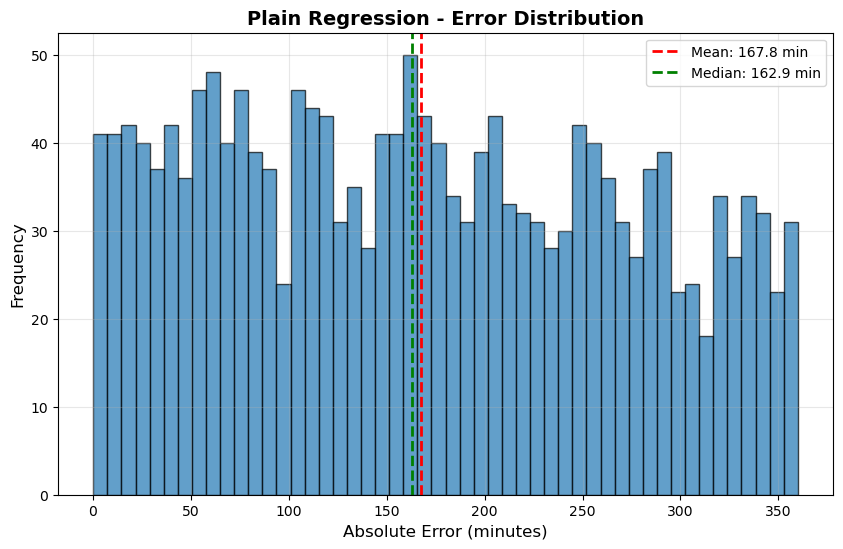

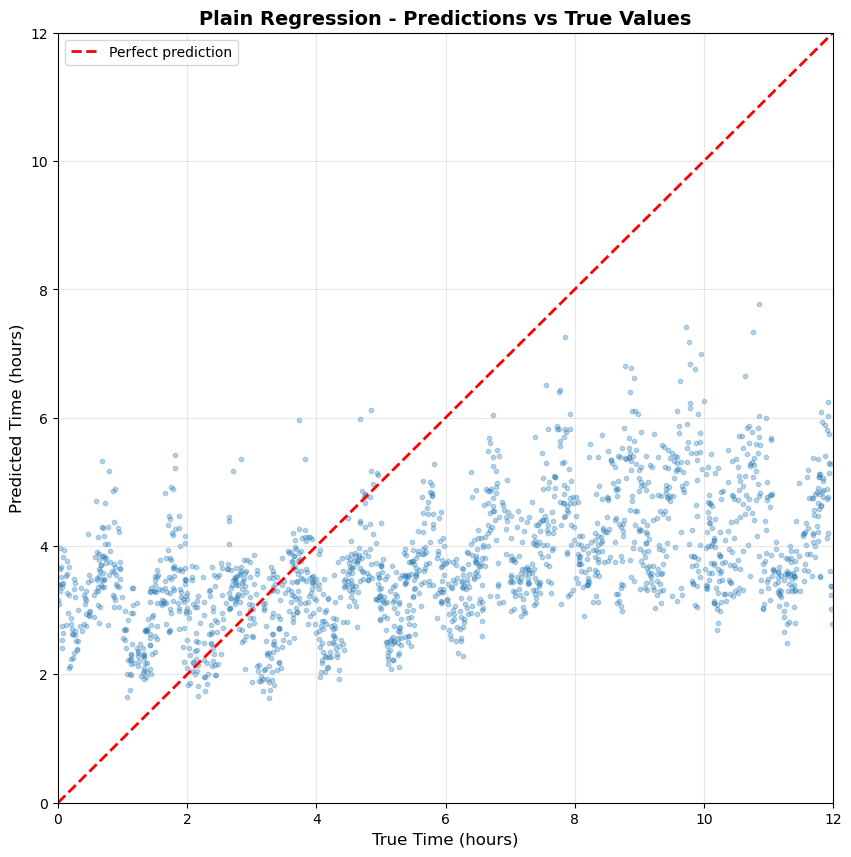

In [6]:
print("TASK 2.B: PLAIN REGRESSION MODEL")

# Prepare labels for plain regression
y_train_reg = labels_to_hours_float(y_train)
y_val_reg = labels_to_hours_float(y_val)
y_test_reg = labels_to_hours_float(y_test)

print(f"\nRegression labels - Train: {y_train_reg.shape}, Val: {y_val_reg.shape}, Test: {y_test_reg.shape}")
print(f"Label range: [{y_train_reg.min():.2f}, {y_train_reg.max():.2f}] hours")

# Build and compile model
model_reg = build_cnn_regression(X_train.shape[1:])
model_reg.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)
model_reg.summary()

# Callbacks
callbacks_reg = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', patience=5, factor=0.5, verbose=1, min_lr=1e-7
    )
]

# Train
print("\nTraining plain regression model...")
history_reg = model_reg.fit(
    X_train, y_train_reg,
    validation_data=(X_val, y_val_reg),
    epochs=50,
    batch_size=128,
    verbose=1,
    callbacks=callbacks_reg
)

# Evaluate
print("\nEvaluating plain regression model on test set...")
preds_reg = model_reg.predict(X_test, verbose=0).flatten()
preds_reg_mod = np.mod(preds_reg, 12.0) # wrap around at 12 hours

metrics_reg = print_metrics(preds_reg_mod, y_test_reg, "PLAIN REGRESSION")

# Visualizations
plot_error_histogram(metrics_reg['errors'], "Plain Regression", "images/plain_reg_errors.png")
plot_predictions_vs_true(preds_reg_mod, y_test_reg, "Plain Regression", "images/plain_reg_scatter.png")

In [7]:
print("TASK 2.D: PERIODIC (SIN/COS) REGRESSION MODEL") #optional task but we used to compare performance to plain

# Prepare labels for periodic regression
y_train_sc = labels_to_sin_cos(y_train)
y_val_sc = labels_to_sin_cos(y_val)
y_test_sc = labels_to_sin_cos(y_test)

print(f"\nPeriodic labels - Train: {y_train_sc.shape}, Val: {y_val_sc.shape}, Test: {y_test_sc.shape}")
print(f"Cos range: [{y_train_sc[:,0].min():.2f}, {y_train_sc[:,0].max():.2f}]")
print(f"Sin range: [{y_train_sc[:,1].min():.2f}, {y_train_sc[:,1].max():.2f}]")

# Build and compile model
model_sc = build_cnn_sin_cos(X_train.shape[1:])
model_sc.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),  
    loss='mse',
    metrics=['mae']
)
model_sc.summary()

# Callbacks
callbacks_sc = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', patience=8, factor=0.5, verbose=1, min_lr=1e-7
    ),
    keras.callbacks.ModelCheckpoint(
        'best_periodic_model.keras', 
        monitor='val_loss', 
        save_best_only=True, 
        verbose=1
    )
]

# Train periodic regression model
print("\nTraining periodic regression model...")
history_sc = model_sc.fit(
    X_train, y_train_sc,
    validation_data=(X_val, y_val_sc),
    epochs=60,
    batch_size=128,
    verbose=1,
    callbacks=callbacks_sc
)


TASK 2.D: PERIODIC (SIN/COS) REGRESSION MODEL

Periodic labels - Train: (14400, 2), Val: (1800, 2), Test: (1800, 2)
Cos range: [-1.00, 1.00]
Sin range: [-1.00, 1.00]


Model: "cnn_periodic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 10,791,906 (41.17 MB)

 Trainable params: 10,790,498 (41.16 MB)

 Non-trainable params: 1,408 (5.50 KB)


Training periodic regression model...
Epoch 1/60
  1/113 ━━━━━━━━━━━━━━━━━━━━ 5:52 3s/step - loss: 0.9299 - mae: 0.7840113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.7884 - mae: 0.7093
Epoch 1: val_loss improved from None to 0.86096, saving model to best_periodic_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - loss: 0.6694 - mae: 0.6439 - val_loss: 0.8610 - val_mae: 0.7548 - learning_rate: 3.0000e-04
Epoch 2/60
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.4866 - mae: 0.5331
Epoch 2: val_loss did not improve from 0.86096
113/113 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - loss: 0.4567 - mae: 0.5152 - val_loss: 0.8853 - val_mae: 0.7663 - learning_rate: 3.0000e-04
Epoch 3/60
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.4061 - mae: 0.4833
Epoch 3: val_loss improved from 0.86096 to 0.75957, saving model to best_periodic_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - loss: 0.3925 - mae: 0.4735 - val_loss: 0.7596 - val_mae: 0.7220 - learning_rate: 3.0000e-04
Epoch 4/60


In [14]:
# Load best model
model_sc = keras.models.load_model('best_periodic_model.keras')

# Evaluate
print("\nEvaluating periodic regression model on test set...")
pred_sc = model_sc.predict(X_test, verbose=0) 


pred_hours_sc = sin_cos_to_hours(pred_sc)
true_hours_sc = sin_cos_to_hours(y_test_sc)

metrics_sc = print_metrics(pred_hours_sc, true_hours_sc, "PERIODIC REGRESSION")


Evaluating periodic regression model on test set...
PERIODIC REGRESSION - TEST SET RESULTS
Mean Absolute Error:    12.35 minutes
Median Absolute Error:  9.79 minutes
Std Deviation:          11.47 minutes
Max Error:              172.99 minutes

Accuracy within thresholds:
  Within 5 minutes:     26.2%
  Within 10 minutes:    50.8%
  Within 15 minutes:    69.8%
  Within 30 minutes:    94.7%


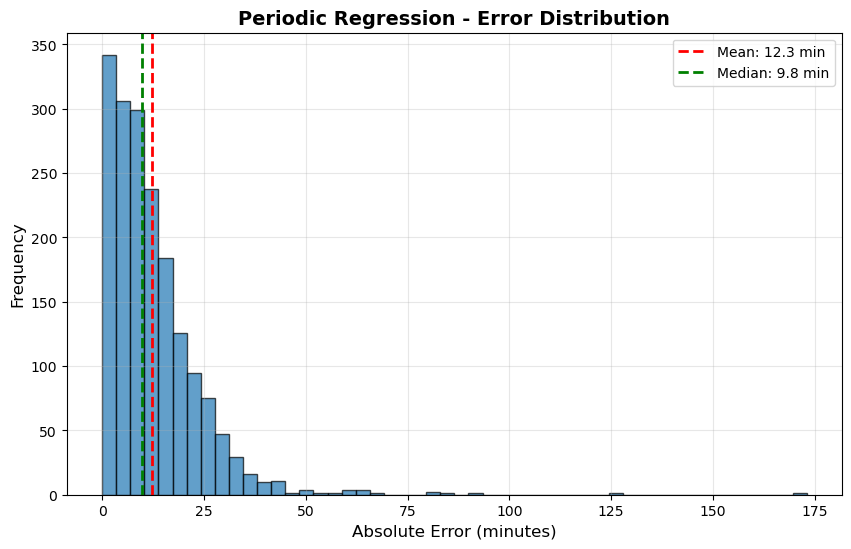

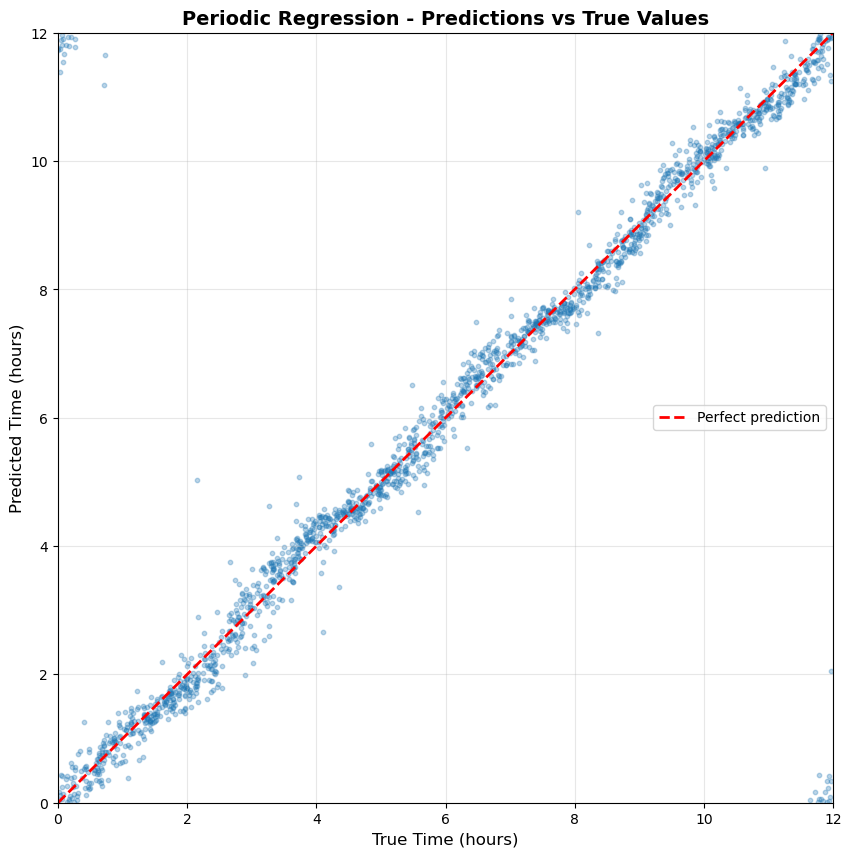

In [15]:
# Visualizations
plot_error_histogram(metrics_sc['errors'], "Periodic Regression", "images/periodic_reg_errors.png")
plot_predictions_vs_true(pred_hours_sc, true_hours_sc, "Periodic Regression", "images/periodic_reg_scatter.png")

FINAL COMPARISON

Metric                         Plain Regression     Periodic Regression 
--------------------------------------------------------------------------------
Mean Error (min)               167.75               12.35               
Median Error (min)             162.91               9.79                
Std Dev (min)                  101.86               11.47               
Max Error (min)                359.96               172.99              
Within 10 min (%)              3.2                  50.8                
Within 15 min (%)              4.8                  69.8                

Improvement: 92.6%


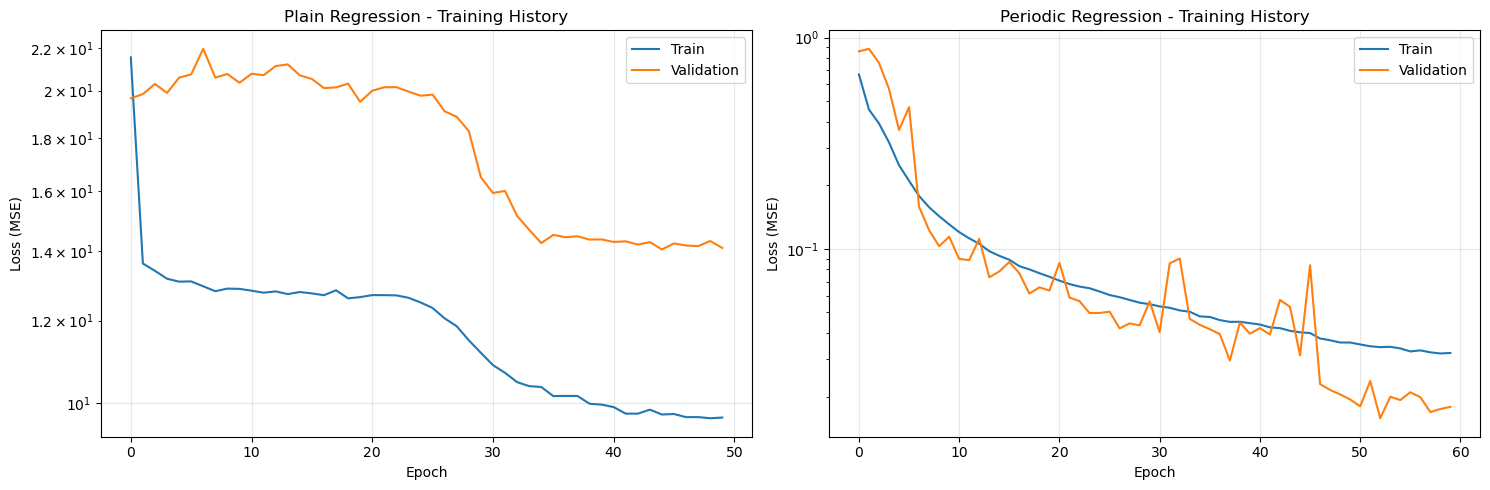

In [10]:
#COMPARISON

print("FINAL COMPARISON")

print("\n{:<30} {:<20} {:<20}".format("Metric", "Plain Regression", "Periodic Regression"))
print("-" * 80)
print("{:<30} {:<20.2f} {:<20.2f}".format("Mean Error (min)", metrics_reg['mean'], metrics_sc['mean']))
print("{:<30} {:<20.2f} {:<20.2f}".format("Median Error (min)", metrics_reg['median'], metrics_sc['median']))
print("{:<30} {:<20.2f} {:<20.2f}".format("Std Dev (min)", metrics_reg['std'], metrics_sc['std']))
print("{:<30} {:<20.2f} {:<20.2f}".format("Max Error (min)", metrics_reg['max'], metrics_sc['max']))
print("{:<30} {:<20.1f} {:<20.1f}".format("Within 10 min (%)", metrics_reg['within_10'], metrics_sc['within_10']))
print("{:<30} {:<20.1f} {:<20.1f}".format("Within 15 min (%)", metrics_reg['within_15'], metrics_sc['within_15']))

improvement = ((metrics_reg['mean'] - metrics_sc['mean']) / metrics_reg['mean']) * 100
print(f"\nImprovement: {improvement:.1f}%")

# Plot training history comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history_reg.history['loss'], label='Train')
axes[0].plot(history_reg.history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Plain Regression - Training History')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

axes[1].plot(history_sc.history['loss'], label='Train')
axes[1].plot(history_sc.history['val_loss'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss (MSE)')
axes[1].set_title('Periodic Regression - Training History')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

plt.tight_layout()
plt.savefig('images/training_history_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

